<a href="https://colab.research.google.com/github/SabahiJ/DataScienceFinalProject/blob/main/Financial_Sentiment_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install newsapi-python

In [17]:
# Phase 1: News Data Collection & Ingestion
# Import required libraries
import os
import time
import pandas as pd
from datetime import datetime, timedelta
from newsapi import NewsApiClient

# API key configuration
API_KEY = "6fc24465eeb54281b7efa2114bc22223"

# Output directory
os.makedirs("data", exist_ok=True)

# Initialize NewsAPI client
newsapi = NewsApiClient(api_key=API_KEY)

# Define search query
query = "Nvidia OR NVDA"

# Define financial sentiment-related keywords
sentiment_keywords = [
    "bullish", "bearish", "uptrend", "downtrend", "rally", "plunge", "spike", "drop",
    "soar", "slump", "decline", "jump", "rebound", "surge", "fall", "gain", "beat estimates",
    "miss estimates", "guidance", "forecast", "warning", "record high", "record low",
    "growth", "slowdown", "volatile", "volatility", "recession", "earnings", "strong results",
    "disappoint", "underperform", "outperform", "loss", "profit", "buy", "sell", "upgrade", "downgrade"
]

# Function to check if a headline contains relevant sentiment keywords
def is_sentiment_relevant(headline):
    headline = str(headline).lower()
    return any(keyword in headline for keyword in sentiment_keywords)

# Initialize output container
filtered_articles = []

# Time slicing: break the last 30 days into 5 intervals of 6 days each
end_date = datetime.today()
start_date = end_date - timedelta(days=30)
interval_days = 6

while start_date < end_date:
    slice_from = start_date.strftime('%Y-%m-%d')
    slice_to = (start_date + timedelta(days=interval_days)).strftime('%Y-%m-%d')

    try:
        print(f"Fetching from {slice_from} to {slice_to}...")
        articles = newsapi.get_everything(
            q=query,
            language="en",
            from_param=slice_from,
            to=slice_to,
            sort_by="publishedAt",
            page_size=100,
            page=1
        )

        for article in articles["articles"]:
            headline = article["title"]
            if is_sentiment_relevant(headline):
                filtered_articles.append([
                    article["publishedAt"][:10],
                    "Nvidia",
                    article["source"]["name"],
                    headline,
                    article["url"]
                ])

        time.sleep(1)

    except Exception as e:
        print(f"Error fetching from {slice_from} to {slice_to}: {e}")

    # Move to next slice
    start_date += timedelta(days=interval_days)

# Convert to DataFrame
df_filtered = pd.DataFrame(filtered_articles, columns=["Date", "Stock", "Source", "Headline", "URL"])

# Save to CSV
df_filtered.to_csv("data/nvidia_news_raw.csv", index=False)
print(f"{len(df_filtered)} relevant Nvidia headlines saved to 'data/nvidia_news_raw.csv'")


Fetching from 2025-04-10 to 2025-04-16...
Fetching from 2025-04-16 to 2025-04-22...
Fetching from 2025-04-22 to 2025-04-28...
Fetching from 2025-04-28 to 2025-05-04...
Fetching from 2025-05-04 to 2025-05-10...
114 relevant Nvidia headlines saved to 'data/nvidia_news_raw.csv'


In [22]:
# Phase 1: Stock Price Collection for Nvidia

# Uses Alpha Vantage FREE endpoint (TIME_SERIES_DAILY) - Goal: Fetch prices to match T+1 sentiment data

import requests
import pandas as pd
from datetime import datetime

# Step 1: Set up Alpha Vantage API parameters
API_KEY = "PTCV59QLK39T51PL"  # Your Alpha Vantage API key
SYMBOL = "NVDA"
FUNCTION = "TIME_SERIES_DAILY"  # Free endpoint

# Step 2: Load sentiment-labeled dataset to extract headline dates
sentiment_df = pd.read_csv("data/nvidia_news_labeled.csv")
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])

# Step 3: Define required date range (T+1 lag)
min_date = sentiment_df["Date"].min() + pd.Timedelta(days=1)
max_date = sentiment_df["Date"].max() + pd.Timedelta(days=1)

# Step 4: Request data from Alpha Vantage
url = f"https://www.alphavantage.co/query?function={FUNCTION}&symbol={SYMBOL}&apikey={API_KEY}&outputsize=full"
response = requests.get(url)
data = response.json()

# Step 5: Check for data presence
if "Time Series (Daily)" not in data:
    raise Exception(f"❌ API returned no usable data: {data.get('Note', data)}")

# Step 6: Parse relevant records only
daily_prices = data["Time Series (Daily)"]
price_data = []

for date_str, values in daily_prices.items():
    try:
        date = pd.to_datetime(date_str)
        if min_date <= date <= max_date:
            open_price = float(values["1. open"])
            close_price = float(values["4. close"])
            price_change = close_price - open_price
            price_direction = "Up" if price_change > 0 else "Down"

            price_data.append({
                "Price_Date": date.strftime("%Y-%m-%d"),
                "Open": open_price,
                "Close": close_price,
                "Price_Change": round(price_change, 2),
                "Price_Direction": price_direction
            })
    except Exception as err:
        print(f"Skipping malformed record on {date_str}: {err}")

# Step 7: Convert to DataFrame and validate
if not price_data:
    raise ValueError("❌ No data matched the sentiment date range.")

price_df = pd.DataFrame(price_data).sort_values("Price_Date")
price_df.to_csv("data/nvidia_price_data.csv", index=False)

# Step 8: Preview results
print(f"✅ Price data collected and saved to 'data/nvidia_price_data.csv' ({len(price_df)} rows)")
print(price_df.head())


✅ Price data collected and saved to 'data/nvidia_price_data.csv' (16 rows)
    Price_Date     Open   Close  Price_Change Price_Direction
15  2025-04-17  104.450  101.49         -2.96            Down
14  2025-04-21   98.770   96.91         -1.86            Down
13  2025-04-22   98.780   98.89          0.11              Up
12  2025-04-23  104.520  102.71         -1.81            Down
11  2025-04-24  103.475  106.43          2.96              Up


In [18]:
pip install transformers

In [19]:
# Phase 2: Sentiment Classification (FinBERT + VADER) - Goal: Clean financial news text and label sentiment using FinBERT and VADER

# 1. Import required libraries
import pandas as pd
import re
from transformers import pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER's lexicon (used to analyze sentiment)
nltk.download("vader_lexicon")

# 2. Load Nvidia news dataset collected in Phase 1
df = pd.read_csv("/content/data/nvidia_news_raw.csv")

# 3. Text Cleaning - Define function to clean text: lowercase and remove special characters
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and non-letter characters
    return text.strip()

# Apply cleaning function to each headline and store in new column
df["Cleaned_Headline"] = df["Headline"].apply(clean_text)

# 4. Load FinBERT model - FinBERT is a transformer model trained on financial news and reports
# It classifies text into positive, negative, or neutral
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# 5. Load VADER sentiment analyzer - VADER is a rule-based model designed for general short text sentiment analysis
vader = SentimentIntensityAnalyzer()

# 6. Define a function to interpret VADER's compound score as a sentiment label
# - score > 0.05 is positive
# - score < -0.05 is negative
# - in between is neutral
def get_vader_sentiment(text):
    score = vader.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# 7. Apply both models to the cleaned headlines - For each headline, assign sentiment using FinBERT (financial NLP)
# and VADER (general rule-based lexicon)
df["FinBERT_Sentiment"] = df["Cleaned_Headline"].apply(lambda x: finbert(x)[0]["label"])
df["VADER_Sentiment"] = df["Cleaned_Headline"].apply(get_vader_sentiment)

# 8. Save the labeled dataset
# Export as CSV to be used in future stages such as analysis and comparison
df.to_csv("data/nvidia_news_labeled.csv", index=False)

# 9. Output sentiment distributions for both models
# This helps assess how each model is labeling the dataset overall
print("FinBERT Sentiment Distribution:")
print(df["FinBERT_Sentiment"].value_counts())

print("\nVADER Sentiment Distribution:")
print(df["VADER_Sentiment"].value_counts())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


FinBERT Sentiment Distribution:
FinBERT_Sentiment
neutral     43
negative    42
positive    29
Name: count, dtype: int64

VADER Sentiment Distribution:
VADER_Sentiment
negative    42
neutral     37
positive    35
Name: count, dtype: int64


In [23]:

# Phase 3: Market Linkage & Sentiment Matching (T+1 Merge) - Objective: Link each financial news headline (T) with Nvidia's
# next-day (T+1) market movement to evaluate predictive sentiment

import pandas as pd

# Step 1: Load sentiment-labeled news data and stock price data - Sentiment: labeled with FinBERT and VADER (Phase 2) - Price: open/close/price_change labels (Phase 1 extension)
sentiment_df = pd.read_csv("/content/data/nvidia_news_labeled.csv")
price_df = pd.read_csv("/content/data/nvidia_price_data.csv")

# Step 2: Convert date columns to datetime format - Ensures accurate T+1 date logic and merge operations
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])
price_df["Price_Date"] = pd.to_datetime(price_df["Price_Date"])

# Step 3: Create Match_Date column (T + 1) - Tracking stock reaction one day after the sentiment occurs - This new date will be matched against the stock price records
sentiment_df["Match_Date"] = sentiment_df["Date"] + pd.Timedelta(days=1)

# Step 4: Perform inner merge on T+1 match logic - sentiment_df[Match_Date] == price_df[Price_Date]
# - Retains only rows with complete sentiment and price info
merged_df = pd.merge(
    sentiment_df,
    price_df,
    left_on="Match_Date",
    right_on="Price_Date",
    how="inner"
)

# Step 5: Select and reorder final evaluation columns - Keeps only relevant attributes for performance comparison
final_df = merged_df[[
    "Date",                 # Original headline date (T)
    "Headline",             # News text
    "FinBERT_Sentiment",    # FinBERT label
    "VADER_Sentiment",      # VADER label
    "Price_Date",           # T+1 price date
    "Open", "Close",        # Price values
    "Price_Change",         # Numeric change
    "Price_Direction"       # Categorical label: "Up"/"Down"
]]

# Step 6: Export merged dataset to CSV - Used for sentiment accuracy analysis in Phase 4
final_df.to_csv("data/nvidia_sentiment_vs_market.csv", index=False)

# Step 7: Print merge result summary and preview data
print(f"✅ Merged dataset created with {len(final_df)} aligned records.")
print(final_df.head())

✅ Merged dataset created with 87 aligned records.
        Date                                           Headline  \
0 2025-04-16  2 Dividend Stocks to Buy ASAP If You’re Bettin...   
1 2025-04-16  U.S. Stocks Drop As Nvidia Slides And The Fog ...   
2 2025-04-16  S&P 500 sinks as tech stocks fall amid thicken...   
3 2025-04-16  S&P 500 sinks as tech stocks fall amid thicken...   
4 2025-04-16  Trump's Trade War Ripples Through Business Wor...   

  FinBERT_Sentiment VADER_Sentiment Price_Date    Open   Close  Price_Change  \
0           neutral        negative 2025-04-17  104.45  101.49         -2.96   
1          negative        negative 2025-04-17  104.45  101.49         -2.96   
2          negative        negative 2025-04-17  104.45  101.49         -2.96   
3          negative        negative 2025-04-17  104.45  101.49         -2.96   
4           neutral        negative 2025-04-17  104.45  101.49         -2.96   

  Price_Direction  
0            Down  
1            Down  
2     

In [24]:
# Phase 3: One-to-One Merge of Sentiment and Price
# Goal: Link one headline per day with next-day market movement

import pandas as pd

# Step 1: Load datasets
sentiment_df = pd.read_csv("data/nvidia_news_labeled.csv")
price_df = pd.read_csv("data/nvidia_price_data.csv")

# Step 2: Convert to datetime
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])
price_df["Price_Date"] = pd.to_datetime(price_df["Price_Date"])

# Step 3: Drop duplicate headlines for the same date
# - Keeps only the first headline per T-date
sentiment_df = sentiment_df.sort_values("Date").drop_duplicates("Date", keep="first")

# Step 4: Add Match_Date for T+1 alignment
sentiment_df["Match_Date"] = sentiment_df["Date"] + pd.Timedelta(days=1)

# Step 5: Merge with T+1 price data
merged_df = pd.merge(
    sentiment_df,
    price_df,
    left_on="Match_Date",
    right_on="Price_Date",
    how="inner"
)

# Step 6: Select output columns
final_df = merged_df[[
    "Date", "Headline",
    "FinBERT_Sentiment", "VADER_Sentiment",
    "Price_Date", "Open", "Close",
    "Price_Change", "Price_Direction"
]]

# Step 7: Export to CSV
final_df.to_csv("data/nvidia_sentiment_vs_market_deduped.csv", index=False)

# Step 8: Output confirmation
print(f"✅ Deduplicated merged dataset created with {len(final_df)} records.")
print(final_df.head())


✅ Deduplicated merged dataset created with 4 records.
        Date                                           Headline  \
0 2025-04-16  2 Dividend Stocks to Buy ASAP If You’re Bettin...   
1 2025-04-22  Nvidia-backed CoreWeave gets largely bullish c...   
2 2025-04-28  Dan Niles Says NVIDIA (NVDA) $5.5 Billion Char...   
3 2025-05-04  Headlands Technologies LLC Buys Shares of 129,...   

  FinBERT_Sentiment VADER_Sentiment Price_Date     Open   Close  Price_Change  \
0           neutral        negative 2025-04-17  104.450  101.49         -2.96   
1          positive         neutral 2025-04-23  104.520  102.71         -1.81   
2          negative        negative 2025-04-29  107.670  109.02          1.35   
3           neutral        positive 2025-05-05  112.905  113.82          0.91   

  Price_Direction  
0            Down  
1            Down  
2              Up  
3              Up  


In [25]:
# Phase 3: Market Linkage & Data Matching
# Objective: Match daily sentiment with next-day stock price while enforcing a one-to-one relationship per day

import pandas as pd

# Step 1: Load preprocessed sentiment and stock price data
sentiment_df = pd.read_csv("data/nvidia_news_labeled.csv")     # Includes FinBERT and VADER results
price_df = pd.read_csv("data/nvidia_price_data.csv")           # Daily stock prices with open/close

# Step 2: Convert date columns to datetime for consistency
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])
price_df["Price_Date"] = pd.to_datetime(price_df["Price_Date"])

# Step 3: Drop duplicate sentiment entries for the same day - Keeps only the first headline per unique T-date (sentiment day)
# - Ensures each T-date contributes only once to analysis
sentiment_df = sentiment_df.sort_values("Date").drop_duplicates("Date", keep="first")

# Step 4: Create a T+1 matching key by shifting dates forward - This allows us to match each sentiment record to next-day price
sentiment_df["Match_Date"] = sentiment_df["Date"] + pd.Timedelta(days=1)

# Step 5: Perform inner join using Match_Date and Price_Date - This combines T-day sentiment with T+1 day stock price
merged_df = pd.merge(
    sentiment_df,
    price_df,
    left_on="Match_Date",
    right_on="Price_Date",
    how="inner"
)

# Step 6: Select and reorder only relevant columns for evaluation - Keeps text, sentiment, market movement features
final_df = merged_df[[
    "Date",               # T date: headline publication
    "Headline",           # News text
    "FinBERT_Sentiment",  # Output from FinBERT model
    "VADER_Sentiment",    # Output from VADER model
    "Price_Date",         # T+1 market date
    "Open",               # Market open price (T+1)
    "Close",              # Market close price (T+1)
    "Price_Change",       # Numerical price change (Close - Open)
    "Price_Direction"     # Categorical label: Up/Down
]]

# Step 7: Save the merged dataset for evaluation in Phase 4
final_df.to_csv("data/nvidia_sentiment_vs_market_.csv", index=False)

# Step 8: Output summary and preview to verify alignment
print(f"✅ Deduplicated merged dataset created with {len(final_df)} records.")
print(final_df.head())


✅ Deduplicated merged dataset created with 4 records.
        Date                                           Headline  \
0 2025-04-16  2 Dividend Stocks to Buy ASAP If You’re Bettin...   
1 2025-04-22  Nvidia-backed CoreWeave gets largely bullish c...   
2 2025-04-28  Dan Niles Says NVIDIA (NVDA) $5.5 Billion Char...   
3 2025-05-04  Headlands Technologies LLC Buys Shares of 129,...   

  FinBERT_Sentiment VADER_Sentiment Price_Date     Open   Close  Price_Change  \
0           neutral        negative 2025-04-17  104.450  101.49         -2.96   
1          positive         neutral 2025-04-23  104.520  102.71         -1.81   
2          negative        negative 2025-04-29  107.670  109.02          1.35   
3           neutral        positive 2025-05-05  112.905  113.82          0.91   

  Price_Direction  
0            Down  
1            Down  
2              Up  
3              Up  


 FinBERT Evaluation Metrics
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00       1.0
          Up       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0


 VADER Evaluation Metrics
              precision    recall  f1-score   support

        Down       0.50      1.00      0.67         1
          Up       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



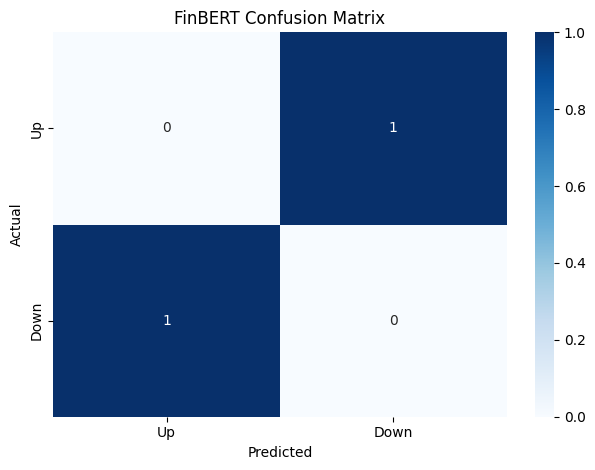

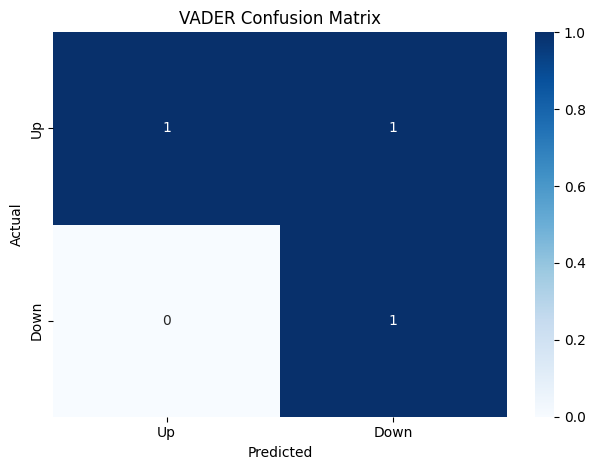

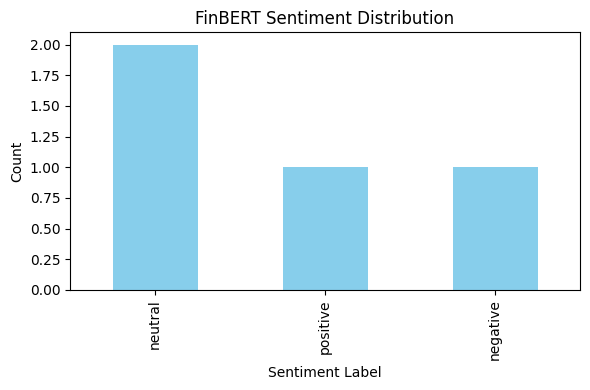

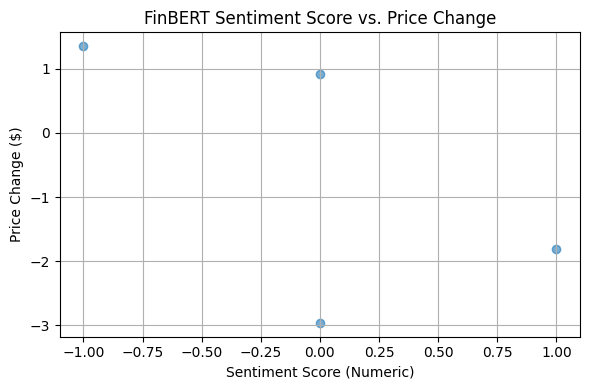

In [27]:
# Phase 4: Evaluation & Metrics
# Objective: Quantitatively evaluate how well sentiment models - predict next-day stock direction based on news headlines

# Step 1: Install essential libraries (if using Google Colab)
!pip install scikit-learn matplotlib seaborn

# Step 2: Import Python libraries for analysis and visualization
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Load the sentiment-market aligned dataset (Phase 3 output)
# - This dataset links each news headline's sentiment with its next-day price direction
df = pd.read_csv("/content/data/nvidia_sentiment_vs_market_.csv")

# Step 4: Filter data for binary sentiment only - Remove 'neutral' to enable binary classification: Bullish vs Bearish (mapped to Up vs Down)
finbert_eval = df[df["FinBERT_Sentiment"].isin(["positive", "negative"])].copy()
vader_eval = df[df["VADER_Sentiment"].isin(["positive", "negative"])].copy()

# Step 5: Map sentiment to market direction
# - positive → Up
# - negative → Down
# - This mapping allows direct comparison with actual market movement
sentiment_to_direction = {"positive": "Up", "negative": "Down"}
finbert_eval["Predicted_Direction"] = finbert_eval["FinBERT_Sentiment"].map(sentiment_to_direction)
vader_eval["Predicted_Direction"] = vader_eval["VADER_Sentiment"].map(sentiment_to_direction)

# Step 6: Generate classification performance reports - Metrics: Accuracy, Precision, Recall, F1-score
# - These measure how closely sentiment direction aligns with actual market direction
print(" FinBERT Evaluation Metrics")
print(classification_report(finbert_eval["Price_Direction"], finbert_eval["Predicted_Direction"]))

print("\n VADER Evaluation Metrics")
print(classification_report(vader_eval["Price_Direction"], vader_eval["Predicted_Direction"]))

# Step 7: Visualize confusion matrices - Confusion matrices show how often predictions match or misclassify direction
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["Up", "Down"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Up", "Down"], yticklabels=["Up", "Down"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(finbert_eval["Price_Direction"], finbert_eval["Predicted_Direction"], "FinBERT Confusion Matrix")
plot_conf_matrix(vader_eval["Price_Direction"], vader_eval["Predicted_Direction"], "VADER Confusion Matrix")

# Step 8: Plot FinBERT sentiment distribution - Bar chart summarizing how often each sentiment label was predicted
plt.figure(figsize=(6, 4))
df["FinBERT_Sentiment"].value_counts().plot(kind="bar", color="skyblue")
plt.title("FinBERT Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Step 9: Visualize sentiment polarity vs. actual price change - This scatter plot assesses if more bullish sentiment relates to higher price movement
sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}
df["Sentiment_Score"] = df["FinBERT_Sentiment"].map(sentiment_map)

plt.figure(figsize=(6, 4))
plt.scatter(df["Sentiment_Score"], df["Price_Change"], alpha=0.6)
plt.title("FinBERT Sentiment Score vs. Price Change")
plt.xlabel("Sentiment Score (Numeric)")
plt.ylabel("Price Change ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
